# Sabermetrics - Starter Code

In this code, you will be using the output of other peoples "models" to come up with a meta prediction (or an _ensemble_ model) about pitcher performance. You will then use the prediction to choose which veteran pitchers to sign.

The right way to think about this exercise is that you will need to make all of the important modeling decisions except for building the model. We will be looking at various ways to measure the performance of our models, and then you will have an opportunity to explore different ways to combine the existing predictions in order to make a better meta-prediction.

## Importing

We import stuff like always. Though there are some changes from notebook to notebook. You should figure out what is necessary for your own projects as you are working through them.

In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [35]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

# Read in the data

The data set here is a data set of pitcher information combined with predictions on the IP (or _innings pitched_) and RA9 (or _runs allowed per 9 innings_). These predictions come from four different groups as stated in the case.

In this assignment, we have two data sets `train_saber.csv` and `test_saber.csv`. `train_saber.csv` are predictions for the 2012 season, which has already happened for Billy Beane, so we also have the realizations for IP and RA9 for the 2012 season. We are trying to predict the 2013 season. `test_saber.csv` has all of the currently available information that Billy Beane would have in making his hiring decisions, but it obviously does not have any data from the 2013 season.

In [36]:
train_df = pd.read_csv("train_saber.csv")

In [37]:
display(train_df.head())

,NAME,IP_fans,RA9_fans,IP_marcel,RA9_marcel,IP_rotochamp,RA9_rotochamp,IP_zips,RA9_zips,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,deathDate,birthDate,IP,RA9
0,Aaron Crow,127,4.187402,56,4.132736,150,3.607945,67.3,4.963657,crowaa01,2012,1,KCA,AL,3,1,73,0,0,0,2,194,54,25,4,22,65,0.231,3.48,2,4,1,0,260,20,27,1,2,NaN,1986,11,10,USA,KS,Topeka,NaN,NaN,NaN,NaN,NaN,NaN,Aaron,Crow,Aaron James,195,75,R,R,3/31/2011,9/28/2014,crowa001,crowaa01,NaN,1986-11-10,64.666667,3.757732
1,Aaron Harang,164,4.602863,156,4.701261,180,4.646595,133.7,4.712194,haranaa01,2012,1,LAN,NL,10,10,31,31,0,0,0,539,167,72,14,85,131,0.246,3.61,10,4,4,0,786,0,85,9,10,NaN,1978,5,9,USA,CA,San Diego,NaN,NaN,NaN,NaN,NaN,NaN,Aaron,Harang,Aaron Michael,260,79,R,R,5/25/2002,9/27/2014,haraa001,haranaa01,NaN,1978-05-09,179.666667,4.257885
2,Adam Wainwright,196,3.443947,83,3.203417,175,3.771942,173.3,3.411148,wainwad01,2012,1,SLN,NL,14,13,32,32,3,2,0,596,196,87,15,52,184,0.259,3.94,3,5,6,2,831,0,96,9,6,NaN,1981,8,30,USA,GA,Brunswick,NaN,NaN,NaN,NaN,NaN,NaN,Adam,Wainwright,Adam Parrish,235,79,R,R,9/11/2005,9/22/2014,waina001,wainwad01,NaN,1981-08-30,198.666667,4.348993
3,Alex Cobb,103,4.099937,86,4.176469,110,4.209269,122.0,4.351400,cobbal01,2012,1,TBA,AL,11,9,23,23,2,1,0,409,130,61,11,40,106,0.254,4.03,2,8,9,1,569,0,67,3,6,NaN,1987,10,7,USA,MA,Boston,NaN,NaN,NaN,NaN,NaN,NaN,Alex,Cobb,Alexander Miller,200,75,R,R,5/1/2011,9/28/2014,cobba001,cobbal01,NaN,1987-10-07,136.333333,4.422983
4,Alexi Ogando,175,3.826608,130,3.826608,185,4.045271,150.0,4.067137,ogandal01,2012,1,TEX,AL,2,0,58,1,0,0,3,198,49,24,9,17,66,0.203,3.27,1,5,2,0,263,11,26,0,3,NaN,1983,10,5,D.R.,San Pedro de Macoris,San Pedro de Macoris,NaN,NaN,NaN,NaN,NaN,NaN,Alexi,Ogando,Alexi,200,76,R,R,6/15/2010,6/3/2014,ogana001,ogandal01,NaN,1983-10-05,66.000000,3.545455


In [40]:
test_df = pd.read_csv("test_saber.csv")

In [41]:
display(test_df.head())

,NAME,IP_fans,RA9_fans,IP_marcel,RA9_marcel,IP_rotochamp,RA9_rotochamp,IP_zips,RA9_zips,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,deathDate,birthDate,IP,RA9
0,Aaron Crow,66,3.538949,63.7,3.843843,60,3.593394,64.0,4.137848,crowaa01,2013,1,KCA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1986,11,10,USA,KS,Topeka,NaN,NaN,NaN,NaN,NaN,NaN,Aaron,Crow,Aaron James,195,75,R,R,2011-03-31,NaN,crowa001,crowaa01,NaN,1986-11-10,NaN,NaN
1,Adam Wainwright,215,3.462725,159.3,3.996290,195,3.462725,173.7,3.724063,wainwad01,2013,1,SLN,NL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1981,8,30,USA,GA,Brunswick,NaN,NaN,NaN,NaN,NaN,NaN,Adam,Wainwright,Adam Parrish,235,79,R,R,2005-09-11,NaN,waina001,wainwad01,NaN,1981-08-30,NaN,NaN
2,Addison Reed,61,3.789397,53.3,4.595189,60,4.246739,66.7,4.257628,reedad01,2013,1,CHA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,12,27,USA,CA,Montclair,NaN,NaN,NaN,NaN,NaN,NaN,Addison,Reed,Addison Devon,220,76,L,R,2011-09-04,NaN,reeda001,reedad01,NaN,1988-12-27,NaN,NaN
3,Al Alburquerque,62,2.929161,36.0,3.538949,55,3.027162,34.7,4.235849,albural01,2013,1,DET,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1986,6,10,D.R.,San Pedro de Macoris,San Pedro de Macoris,NaN,NaN,NaN,NaN,NaN,NaN,Al,Alburquerque,Alberto Jose,195,72,R,R,2011-04-15,NaN,albua001,albural01,NaN,1986-06-10,NaN,NaN
4,Alex Cobb,164,4.159626,133.7,4.181404,140,3.920066,149.3,4.529854,cobbal01,2013,1,TBA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987,10,7,USA,MA,Boston,NaN,NaN,NaN,NaN,NaN,NaN,Alex,Cobb,Alexander Miller,200,75,R,R,2011-05-01,NaN,cobba001,cobbal01,NaN,1987-10-07,NaN,NaN


In [42]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

In [43]:
summarize_dataframe(train_df)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
NAME,object,0,182,182.0,182,Aaron Crow,1,,,,,,,
IP_fans,int64,0,107,182.0,,,,141.467033,58.286836,48.0,69.0,159.5,191.5,242.0
RA9_fans,float64,0,120,182.0,,,,3.947053,0.647344,2.536494,3.44668,3.974206,4.479864,5.444716
IP_marcel,int64,0,100,182.0,,,,119.445055,51.185879,37.0,64.0,126.5,167.0,208.0
RA9_marcel,float64,0,115,182.0,,,,4.058247,0.534799,2.897289,3.673544,4.001538,4.468931,5.499382
IP_rotochamp,int64,0,28,182.0,,,,136.236264,58.484396,30.0,60.0,155.0,190.0,220.0
RA9_rotochamp,float64,0,107,182.0,,,,4.008146,0.740808,1.825839,3.545079,4.045271,4.608329,5.783644
IP_zips,float64,0,148,182.0,,,,128.71978,53.35577,41.7,70.325,140.0,173.225,237.3
RA9_zips,float64,0,129,182.0,,,,4.192568,0.729662,2.405296,3.698143,4.14367,4.695794,6.341236
playerID,object,0,182,182.0,182,crowaa01,1,,,,,,,


In [44]:
summarize_dataframe(test_df)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
NAME,object,0,191,191.0,191,Aaron Crow,1,,,,,,,
IP_fans,int64,0,99,191.0,,,,139.125654,57.950931,51.0,70.0,158.0,191.0,233.0
RA9_fans,float64,0,120,191.0,,,,3.894982,0.63256,2.450041,3.440947,3.952734,4.371963,5.128753
IP_marcel,float64,0,150,191.0,,,,116.719372,51.228593,34.0,65.0,120.0,165.2,204.3
RA9_marcel,float64,0,117,191.0,,,,4.080666,0.514831,2.754935,3.702285,4.105181,4.453631,5.477204
IP_rotochamp,int64,0,33,191.0,,,,130.026178,59.616091,25.0,60.0,150.0,185.0,220.0
RA9_rotochamp,float64,0,116,191.0,,,,3.979244,0.69107,1.676917,3.52806,4.028957,4.475409,5.488093
IP_zips,float64,0,161,191.0,,,,128.963351,53.051221,23.0,68.65,141.3,169.85,228.3
RA9_zips,float64,0,139,191.0,,,,4.25415,0.754846,1.709584,3.734952,4.235849,4.769414,6.184994
playerID,object,0,191,191.0,191,crowaa01,1,,,,,,,


## Model building

2012 will be the dataset that you use to "train" your ensemble (i.e. decide how to combine the existing predictions over IP and RA9). Once you have the exact way in which you intend to make your ensemble model, you will then need to apply that same combination procedure to the 2013 data (`test_saber.csv`) in order to get your 2013 predictions.

We'll first focus on evaluating the performance of the given predictions in 2012 (for which we have ground truth). We will be using three metrics. The first two are _root mean squared error_ (RMSE) and _mean absolute error_ (MAE). You can read a primer on these metrics [here](https://www.dataquest.io/blog/understanding-regression-error-metrics/). Note the article also talks about MAPE and MPE. Why are we not using those?

The third metric will be familiar to anyone with a background in linear regression, R^2. A good introduction to R^2 can be found [here](https://towardsdatascience.com/statistics-for-machine-learning-r-squared-explained-425ddfebf667). What is useful about R^2?

We will see other metrics as we go through the course, but these are some of the most common.

We will define a function to make it more convenient to run all of the metrics at once.

In [45]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)]})
    display(acc_df.style.hide(axis='index'))

Let's look at the accuracy of the models that we have for IP.

In [46]:
print("Accuracy of IP_fans is:")
accuracy(train_df["IP"], train_df["IP_fans"])

Accuracy of IP_fans is:


RMSE,MAE,R^2
58.481914,40.256410,0.263708


In [47]:
print("Accuracy of IP_marcel is:")
accuracy(train_df["IP"], train_df["IP_marcel"])

Accuracy of IP_marcel is:


RMSE,MAE,R^2
53.509154,39.582418,0.383600


In [48]:
print("Accuracy of IP_rotochamp is:")
accuracy(train_df["IP"], train_df["IP_rotochamp"])

Accuracy of IP_rotochamp is:


RMSE,MAE,R^2
57.659848,39.479853,0.284263


In [49]:
print("Accuracy of IP_zips is:")
accuracy(train_df["IP"], train_df["IP_zips"])

Accuracy of IP_zips is:


RMSE,MAE,R^2
54.523902,39.421612,0.359999


First, notice that not all metrics agree on which model is the best. This means that you have to choose which metric you are going to use to do _model selection_. This is an important choice, and you should give it some thought as you are deciding on how to build your ensemble to evaluate the 2013 pitchers. Each of the metrics penalizes different errors differently. As Billy Beane, what errors do you care about the most?

We will also find it useful to look at the errors the models make themselves. In order to do this, I'm going to make a DataFrame of the errors. Here I am defining an error as `(predicted - actual)`. Sometimes, people will use the opposite definition.

In [50]:
errors_df = pd.DataFrame({"Fans_IP_error": train_df["IP_fans"] - train_df["IP"],
                          "Marcel_IP_error": train_df["IP_marcel"] - train_df["IP"],
                          "Rotochamp_IP_error": train_df["IP_rotochamp"] - train_df["IP"],
                          "Zips_IP_error": train_df["IP_zips"] - train_df["IP"]})

In [51]:
errors_df.head()

,Fans_IP_error,Marcel_IP_error,Rotochamp_IP_error,Zips_IP_error
0,62.333333,-8.666667,85.333333,2.633333
1,-15.666667,-23.666667,0.333333,-45.966667
2,-2.666667,-115.666667,-23.666667,-25.366667
3,-33.333333,-50.333333,-26.333333,-14.333333
4,109.000000,64.000000,119.000000,84.000000


Then, we can get an idea for whether or not or models are _biased_, i.e. whether they systematically over or under predict. We do this by looking at the _mean error_, which is just the average of all the errors.

In [52]:
errors_df.mean(axis=0)

Fans_IP_error         28.344322
Marcel_IP_error        6.322344
Rotochamp_IP_error    23.113553
Zips_IP_error         15.597070
dtype: float64

Are the models biased? In which direction? What does this say about how you should think about combining them? Or put another way, if you use some kind of averaging of these models in order to get your prediction, will your resulting model be biased?

When ensembling, it is often better to use very different models in the ensemble because the diversity of models increases the likelihood of bracketing the true value. Correlation between the model predictions is a good way to measure the similarity of the models. Note that a higher correlation, means the models are more similar. We can easily computer the _correlation matrix_ from the `errors_df`.

In [53]:
errors_df.corr()

,Fans_IP_error,Marcel_IP_error,Rotochamp_IP_error,Zips_IP_error
Fans_IP_error,1.000000,0.890679,0.948952,0.904915
Marcel_IP_error,0.890679,1.000000,0.881627,0.894794
Rotochamp_IP_error,0.948952,0.881627,1.000000,0.891549
Zips_IP_error,0.904915,0.894794,0.891549,1.000000


## Building Ensembles

Now that we have an understanding of the performance of the underlying models, we can start building an ensemble. Below we are going to build three such simple ensembles.

The first will just be combining the best (Zips) and worst (Fans) models according to MAE. The second will be averaging all of the models. The third will be averaging all models except for Fans (the worst model according to MAE).

In [54]:
IP_pred_2012_best_and_worst = train_df[["IP_fans", "IP_zips"]].mean(axis=1)
IP_pred_2012_all = train_df[["IP_fans", "IP_marcel", "IP_rotochamp", "IP_zips"]].mean(axis=1)
IP_pred_2012_last_three = train_df[["IP_marcel", "IP_rotochamp", "IP_zips"]].mean(axis=1)

In [55]:
print("Performance of best and worst ensemble:")
accuracy(train_df["IP"], IP_pred_2012_best_and_worst)
print("Performance of all ensemble:")
accuracy(train_df["IP"], IP_pred_2012_all)
print("Performance of top three ensemble:")
accuracy(train_df["IP"], IP_pred_2012_last_three)

Performance of best and worst ensemble:


RMSE,MAE,R^2
55.031937,38.695971,0.348017


Performance of all ensemble:


RMSE,MAE,R^2
53.612898,37.929487,0.381207


Performance of top three ensemble:


RMSE,MAE,R^2
52.924817,38.137729,0.396989


How do the models do?

Often times, it is helpful to visualize the performance of our model (or ensemble model in this case). The plot below plots the ensemble prediction (using all models) on the horizontal axis and the realization on the vertical axis. If our model was perfect, where should all of the points be? What can you discern from where the points are?

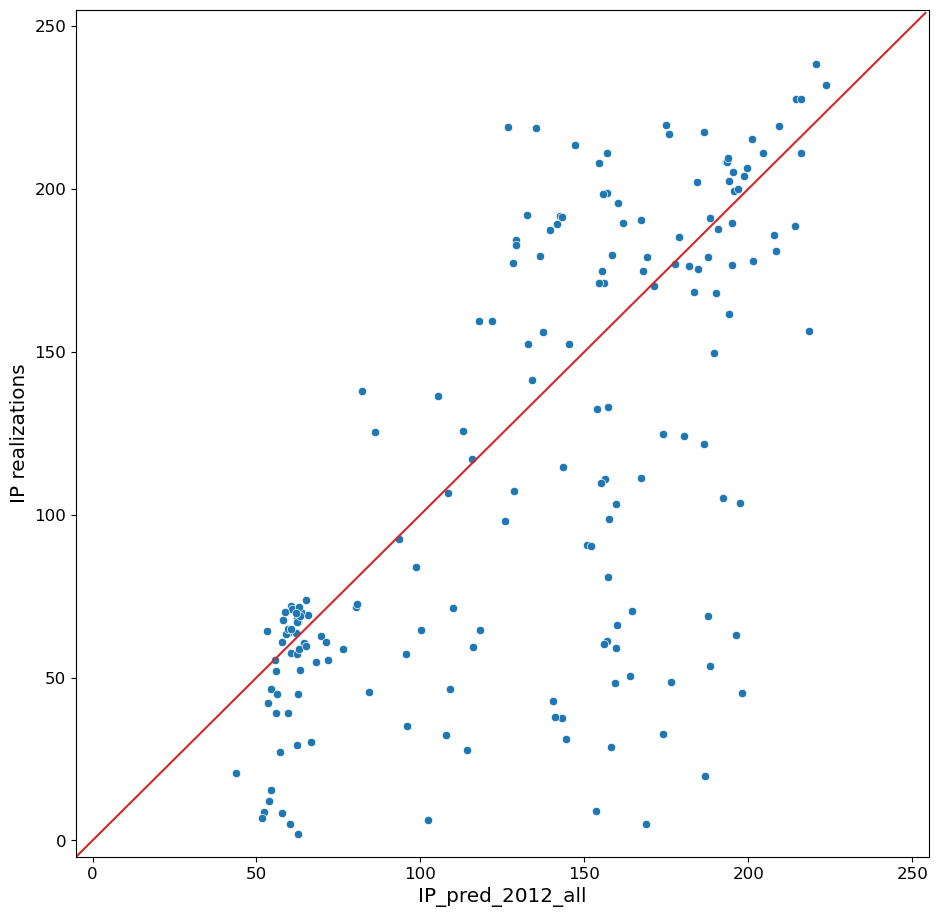

In [56]:
sns.lineplot(x = list(range(-5,255)), y = list(range(-5,255)), color='tab:red')
sns.scatterplot(x = IP_pred_2012_all, y = train_df["IP"])
plt.xlabel("IP_pred_2012_all")
plt.ylabel("IP realizations")
plt.xlim([-5,255])
plt.ylim([-5,255])
plt.show()

# Study bracketing of best-and-worst ensemble

A large reason to ensemble models is because if you can bracket (i.e. the true prediction lies between your model predictions), the average of the model predictions is going to closer to the true prediction than the average model will be. If you do not bracket, then your performance (on average) is no worse than the average model, so you just gain when you are able to successfully bracket.

Therefore, let's look at how often we successfully bracket using Fans and Zips (the worst and best from above). The below line of code identifies every pitcher for which those two models bracket. I encourage you to study the line of code until you convince yourself that this is true.

In [57]:
bracketing = (train_df["IP"] - train_df["IP_fans"])*(train_df["IP"] - train_df["IP_zips"]) <= 0

What is this `bracketing` variable?

In [58]:
bracketing

0      False
1      False
2      False
3      False
4      False
       ...  
177    False
178    False
179    False
180    False
181    False
Length: 182, dtype: bool

It is just a boolean series that has a `True` everytime we bracket. What is the percentage of time we bracket?

In [59]:
bracketing.mean()

0.19230769230769232

When we take the `mean` of a boolean series, it treats all `True` as `1` and all `False` as 0, so we bracket about 19% of the time. How many pitchers is that?

In [60]:
len(train_df[bracketing])

35

`train_df[bracketing]` is just a dataframe with only pitchers that we successfully bracket. If we look at the length of that dataframe (using `len`), we see there are 35 pitchers in it.

We can also directly look at this bracketing in the below plot.

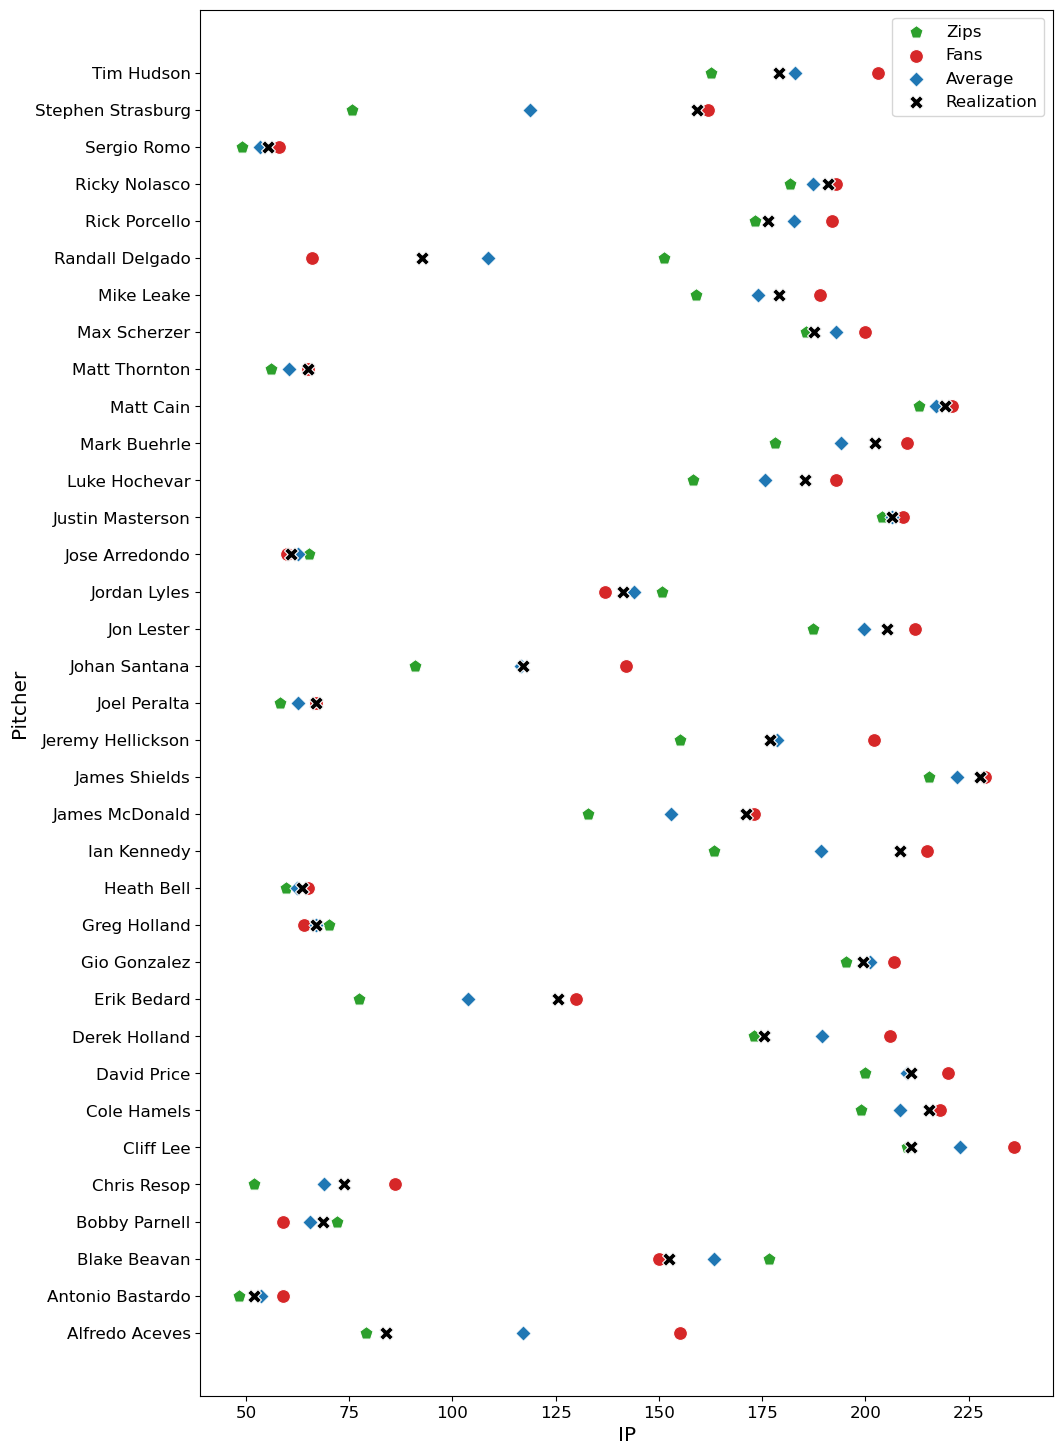

In [61]:
plt.figure(figsize=(11,18))
y_values = range(0, len(train_df[bracketing]))
sns.scatterplot(x = train_df[bracketing]["IP_zips"], y = y_values, marker="p", color="tab:green", label="Zips", s = 100)
sns.scatterplot(x = train_df[bracketing]["IP_fans"], y = y_values, marker="o", color="tab:red", label="Fans", s = 100)
sns.scatterplot(x = IP_pred_2012_best_and_worst[bracketing], y = y_values, marker="D", color="tab:blue", label="Average", s = 60)
sns.scatterplot(x = train_df[bracketing]["IP"], y = y_values, marker="X", color="black", label="Realization", s = 100)
plt.yticks(y_values, train_df[bracketing]['NAME'].values)
plt.xlabel("IP")
plt.ylabel("Pitcher")
plt.show()

## Build Your Own Ensemble

We've looked at some obvious ensembles above. In this section, build your own ensemble.

A couple of tips. First, we have only looked at simple averaging of models above. That is not necessary. You could, for example, take a weighted average. Moreover, you do not have to combine models by averaging. The model predictions are just data, and you can treat them like any other data when it comes to building a predictive model. You will need to build an ensemble for both IP and RA9 to use in your decision process for choosing a pitcher. The better you can predict these values, the better you will do in choosing a pitcher.

Note that after you have chosen how to build your ensemble using the `train_df`, you will then need to use the same construction to actually get predictions from the `test_df` (i.e., if you average the Fans and Zips prediction for `train_df` do the same thing on `test_df`). Don't forget to do this part, and remember the datasets are the same as far as the Fans, Zips, Marcel, and Rotochamp models go, it's just that `test_df` doesn't have the 2013 season realizations.

Save your predictions for 2013 in a variable called `IP_pred_2013` and `RA9_pred_2013`.

After you build your predictions, use them, along with the other data in the case, to choose the pitchers you will sign. You will need to get the predicted IP and RA9 of all of the free agent pitchers in exhibit 4. Below is an easy way to find the indices of all of the pitchers.

In [80]:
free_agents = ["Andy Pettitte",
               "Bartolo Colon",
               "Brandon McCarthy",
               "Francisco Liriano",
               "Hiroki Kuroda",
               "Joe Blanton",
               "Joe Saunders",
               "Kevin Correia",
               "Paul Maholm",
               "Ryan Dempster",
               "Shaun Marcum",
               "Anibal Sanchez",
               "Brett Myers",
               "Hisashi Iwakuma",
               "Jeremy Guthrie",
               "Zack Greinke"]

In [81]:
test_df.loc[test_df["NAME"].isin(free_agents)]

,NAME,IP_fans,RA9_fans,IP_marcel,RA9_marcel,IP_rotochamp,RA9_rotochamp,IP_zips,RA9_zips,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,deathDate,birthDate,IP,RA9
9,Andy Pettitte,145,4.018068,97.7,3.909177,140,3.571616,90.3,4.453631,pettian01,2013,1,NYA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,6,15,USA,LA,Baton Rouge,NaN,NaN,NaN,NaN,NaN,NaN,Andy,Pettitte,Andrew Eugene,235,77,L,L,1995-04-29,NaN,petta001,pettian01,NaN,1972-06-15,NaN,NaN
10,Anibal Sanchez,197,4.039846,177.7,4.137848,200,3.974512,185.0,4.606078,sanchan01,2013,1,DET,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1984,2,27,Venezuela,Aragua,Maracay,NaN,NaN,NaN,NaN,NaN,NaN,Anibal,Sanchez,Anibal Alejandro,205,72,R,R,2006-06-25,NaN,sanca004,sanchan01,NaN,1984-02-27,NaN,NaN
14,Bartolo Colon,135,4.322962,151.0,4.214071,120,4.410075,127.0,4.475409,colonba01,2013,1,OAK,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1973,5,24,D.R.,Puerto Plata,Altamira,NaN,NaN,NaN,NaN,NaN,NaN,Bartolo,Colon,Bartolo,285,71,R,R,1997-04-04,NaN,colob001,colonba01,NaN,1973-05-24,NaN,NaN
21,Brandon McCarthy,158,3.680507,132.7,3.843843,130,4.301184,118.7,4.214071,mccarbr01,2013,1,ARI,NL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983,7,7,USA,CA,Glendale,NaN,NaN,NaN,NaN,NaN,NaN,Brandon,McCarthy,Brandon Patrick,200,79,R,R,2005-05-22,NaN,mccab001,mccarbr01,NaN,1983-07-07,NaN,NaN
25,Brett Myers,178,4.518965,90.3,4.344740,150,4.181404,178.0,4.627856,myersbr01,2013,1,CLE,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980,8,17,USA,FL,Jacksonville,NaN,NaN,NaN,NaN,NaN,NaN,Brett,Myers,Brett Allen,240,76,R,R,2002-07-24,NaN,myerb001,myersbr01,NaN,1980-08-17,NaN,NaN
63,Francisco Liriano,163,4.595189,147.7,5.106975,160,5.019863,154.7,4.050735,liriafr01,2013,1,PIT,NL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983,10,26,D.R.,San Cristobal,San Cristobal,NaN,NaN,NaN,NaN,NaN,NaN,Francisco,Liriano,Francisco Casillas,215,74,L,L,2005-09-05,NaN,lirif001,liriafr01,NaN,1983-10-26,NaN,NaN
73,Hiroki Kuroda,198,3.952734,190.3,3.811176,180,3.647839,186.0,4.638745,kurodhi01,2013,1,NYA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1975,2,10,Japan,Osaka,Osaka,NaN,NaN,NaN,NaN,NaN,NaN,Hiroki,Kuroda,Hiroki,205,73,R,R,2008-04-04,NaN,kuroh001,kurodhi01,NaN,1975-02-10,NaN,NaN
74,Hisashi Iwakuma,179,4.028957,106.3,3.865621,160,3.985401,128.3,4.203182,iwakuhi01,2013,1,SEA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1981,4,12,Japan,Tokyo,Higashi Yamato,NaN,NaN,NaN,NaN,NaN,NaN,Hisashi,Iwakuma,Hisashi,210,75,R,R,2012-04-20,NaN,iwakh001,iwakuhi01,NaN,1981-04-12,NaN,NaN
92,Jeremy Guthrie,196,4.704080,169.0,4.812970,195,4.769414,163.7,4.791192,guthrje01,2013,1,KCA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979,4,8,USA,OR,Roseburg,NaN,NaN,NaN,NaN,NaN,NaN,Jeremy,Guthrie,Jeremy,205,73,R,R,2004-08-28,NaN,guthj001,guthrje01,NaN,1979-04-08,NaN,NaN
98,Joe Blanton,172,4.943639,157.3,5.041641,170,4.497187,130.3,4.889194,blantjo01,2013,1,LAA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980,12,11,USA,KY,Bowling Green,NaN,NaN,NaN,NaN,NaN,NaN,Joe,Blanton,Joseph Matthew,215,75,R,R,2004-09-21,NaN,blanj001,blantjo01,NaN,1980-12-11,NaN,NaN


You can just get the indices (which you can then use to access just the rows from your predictions) with:

In [82]:
free_agent_indices = test_df["NAME"].isin(free_agents)

In [83]:
free_agent_indices

0      False
1      False
2      False
3      False
4      False
       ...  
186    False
187    False
188    False
189    False
190     True
Name: NAME, Length: 191, dtype: bool

The following code will help you more easily read out your predictions for the individual pitchers in order to use the predictions in your decision. Note that until you have the variables `IP_pred_2013` and `RA9_pred_2013`, you will get an error if you try to run the below cell.

In [84]:
pd.DataFrame({'Name': test_df[free_agent_indices]["NAME"], 
              'Prediction IP 2013': IP_pred_2013[free_agent_indices], 
              'Prediction RA9 2013': RA9_pred_2013[free_agent_indices]}).set_index('Name')

,Prediction IP 2013,Prediction RA9 2013
Name,,
Andy Pettitte,106.613089,4.040573
Anibal Sanchez,160.484645,4.276805
Bartolo Colon,110.534532,4.721645
Brandon McCarthy,121.138644,4.442011
Brett Myers,141.816481,4.612705
Francisco Liriano,132.586808,5.305175
Hiroki Kuroda,161.399977,4.026451
Hisashi Iwakuma,134.134435,4.383587
Jeremy Guthrie,155.197924,5.031733


Good luck with the ensembling!

In [149]:
from sklearn.linear_model import LinearRegression

# For IP
X_train_IP = train_df[['IP_fans', 'IP_zips', 'IP_marcel', 'IP_rotochamp']]
y_train_IP = train_df['IP']

reg_IP = LinearRegression().fit(X_train_IP, y_train_IP)
X_test_IP = test_df[['IP_fans', 'IP_zips', 'IP_marcel', 'IP_rotochamp']]
IP_pred_2013 = reg_IP.predict(X_test_IP)

# For RA9
X_train_RA9 = train_df[['RA9_fans', 'RA9_zips', 'RA9_marcel', 'RA9_rotochamp']]
y_train_RA9 = train_df['RA9']

reg_RA9 = LinearRegression().fit(X_train_RA9, y_train_RA9)
X_test_RA9 = test_df[['RA9_fans', 'RA9_zips', 'RA9_marcel', 'RA9_rotochamp']]
RA9_pred_2013 = reg_RA9.predict(X_test_RA9)

# Get the free agent pitchers from test_df
free_agent_df = test_df[test_df["NAME"].isin(free_agents)]

# Create a true copy of the filtered dataframe
free_agent_df = test_df[test_df["NAME"].isin(free_agents)].copy()

# OR when setting the values, you can use .loc
free_agent_df.loc[:, 'IP_pred_2013'] = IP_pred_2013[free_agent_df.index]
free_agent_df.loc[:, 'RA9_pred_2013'] = RA9_pred_2013[free_agent_df.index]

# Add our ensemble predictions to this dataframe
free_agent_df['IP_pred_2013'] = IP_pred_2013[free_agent_df.index]
free_agent_df['RA9_pred_2013'] = RA9_pred_2013[free_agent_df.index]

# Now sort by our predictions to select best pitchers
best_pitchers = free_agent_df.sort_values(by=['RA9_pred_2013', 'IP_pred_2013'], ascending=[True, False])
print(best_pitchers[['NAME', 'IP_pred_2013', 'RA9_pred_2013']])


                  NAME  IP_pred_2013  RA9_pred_2013
73       Hiroki Kuroda    161.399977       4.026451
9        Andy Pettitte    106.613089       4.040573
10      Anibal Sanchez    160.484645       4.276805
74     Hisashi Iwakuma    134.134435       4.383587
190       Zack Greinke    171.099781       4.420135
21    Brandon McCarthy    121.138644       4.442011
155      Ryan Dempster    151.707159       4.561148
145        Paul Maholm    146.903842       4.580779
25         Brett Myers    141.816481       4.612705
163       Shaun Marcum    131.201284       4.667685
14       Bartolo Colon    110.534532       4.721645
100       Joe Saunders    156.080904       4.726472
98         Joe Blanton    133.867141       4.919964
92      Jeremy Guthrie    155.197924       5.031733
118      Kevin Correia    126.888034       5.112434
63   Francisco Liriano    132.586808       5.305175


In [150]:
import pandas as pd

# Read the CSV into a pandas DataFrame
df = pd.read_csv('exhibit_3_time_series_saber.csv')

# Display the first few rows of the dataframe to understand its structure
print(df.head())
# Display the last few rows of the dataframe to understand its structure
print(df.tail())
# Display the dataframe's shape to understand its structure
print(df.shape)
# Display the dataframe's columns to understand its structure
print(df.columns)
# Display the dataframe's index to understand its structure
print(df.index)
# Display the dataframe's info to understand its structure
print(df.info())
# Display the dataframe's describe to understand its structure
print(df.describe())


   Season  League Average RA9  Runs per Win  Dollars per WAR
0    1985            4.411228         9.530         0.575533
1    1986            4.525219         9.645         0.679621
2    1987            4.876988        10.144         0.596358
3    1988            4.224419         9.229         0.658220
4    1989            4.297166         9.230         0.797028
    Season  League Average RA9  Runs per Win  Dollars per WAR
23    2008            4.807966        10.032         4.897393
24    2009            4.788389         9.994         5.129557
25    2010            4.510994         9.643         4.718795
26    2011            4.439932         9.454         5.590431
27    2012            4.552332         9.544         5.781250
(28, 4)
Index(['Season', 'League Average RA9', 'Runs per Win', 'Dollars per WAR'], dtype='object')
RangeIndex(start=0, stop=28, step=1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column             

In [151]:
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Sample data
data = {
    'Season': list(range(1985, 2013)),
    'League Average RA9': [4.411228456, 4.525218848, 4.876987552, 4.224418983, 4.297165992,
                           4.40002351, 4.423282863, 4.239274123, 4.690498772, 4.988778241,
                           4.983163997, 5.192826806, 4.867712014, 4.950197006, 5.264707115,
                           5.283991918, 4.982293104, 4.791971653, 4.901765495, 5.003973668,
                           4.715446317, 5.082461473, 4.986866472, 4.807966466, 4.788389467,
                           4.510994116, 4.439931602, 4.552332164],
    'Runs per Win': [9.53, 9.645, 10.144, 9.229, 9.23, 9.44, 9.479, 9.188, 9.953, 10.439, 10.326,
                     10.599, 10.21, 10.232, 10.714, 10.795, 10.235, 9.991, 10.158, 10.272, 9.971,
                     10.365, 10.25, 10.032, 9.994, 9.643, 9.454, 9.544],
    'Dollars per WAR': [0.575532602, 0.679620853, 0.596357616, 0.658219829, 0.797028138, 1.032016349,
                        1.368916797, 1.917781403, 2.060861423, 1.920673077, 2.05176393, 1.7615,
                        2.070650798, 1.948359788, 2.30229073, 2.769810459, 3.339866267, 3.379084967,
                        3.678666345, 3.601396857, 3.975050916, 4.432115231, 4.417665451, 4.897393233,
                        5.129557096, 4.718794835, 5.590430947, 5.78125]
}
df = pd.DataFrame(data)

# Function to forecast next value based on SimpleExpSmoothing
def forecast_next_value(column_data):
    model = SimpleExpSmoothing(column_data)
    model_fit = model.fit(smoothing_level=0.6, optimized=False)
    forecast = model_fit.forecast(steps=1)
    return forecast.iloc[0]  # Use .iloc[0] instead of forecast[0]

# Forecast the 2013 values
forecasted_values = {
    "League Average RA9": forecast_next_value(df['League Average RA9']),
    "Runs per Win": forecast_next_value(df['Runs per Win']),
    "Dollars per WAR": forecast_next_value(df['Dollars per WAR'])
}

# Print the forecasted 2013 values
for key, value in forecasted_values.items():
    print(f"Estimated 2013 value for {key}: {value:.3f}")


Estimated 2013 value for League Average RA9: 4.539
Estimated 2013 value for Runs per Win: 9.564
Estimated 2013 value for Dollars per WAR: 5.580


In [152]:
# Calculate RMSE for each model using train_df
rmse_IP_fans = np.sqrt(((train_df['IP_fans'] - train_df['IP']) ** 2).mean())
rmse_IP_marcel = np.sqrt(((train_df['IP_marcel'] - train_df['IP']) ** 2).mean())
rmse_IP_rotochamp = np.sqrt(((train_df['IP_rotochamp'] - train_df['IP']) ** 2).mean())

rmse_RA9_fans = np.sqrt(((train_df['RA9_fans'] - train_df['RA9']) ** 2).mean())
rmse_RA9_marcel = np.sqrt(((train_df['RA9_marcel'] - train_df['RA9']) ** 2).mean())
rmse_RA9_rotochamp = np.sqrt(((train_df['RA9_rotochamp'] - train_df['RA9']) ** 2).mean())

# Calculate inverse weights (since lower RMSE is better)
weights_IP = [1/rmse_IP_fans, 1/rmse_IP_marcel, 1/rmse_IP_rotochamp]
weights_IP = [w/sum(weights_IP) for w in weights_IP]

weights_RA9 = [1/rmse_RA9_fans, 1/rmse_RA9_marcel, 1/rmse_RA9_rotochamp]
weights_RA9 = [w/sum(weights_RA9) for w in weights_RA9]

# Predict 2013 IP and RA9 values for the free agents using the weights
free_agent_data = test_df.loc[test_df["NAME"].isin(free_agents)].copy()  # Using .copy() to avoid SettingWithCopyWarning
IP_pred_2013 = free_agent_data[['IP_fans', 'IP_marcel', 'IP_rotochamp']].dot(weights_IP)
RA9_pred_2013 = free_agent_data[['RA9_fans', 'RA9_marcel', 'RA9_rotochamp']].dot(weights_RA9)

# Append the predicted values to free_agent_data DataFrame
free_agent_data['IP_pred_2013'] = IP_pred_2013
free_agent_data['RA9_pred_2013'] = RA9_pred_2013

# Print out the predicted and actual values for each free agent
print(free_agent_data[['NAME', 'IP', 'RA9', 'IP_pred_2013', 'RA9_pred_2013']])


                  NAME  IP  RA9  IP_pred_2013  RA9_pred_2013
9        Andy Pettitte NaN  NaN    126.730435       3.831520
10      Anibal Sanchez NaN  NaN    191.190625       4.050363
14       Bartolo Colon NaN  NaN    135.731551       4.316168
21    Brandon McCarthy NaN  NaN    139.961064       3.943821
25         Brett Myers NaN  NaN    138.012290       4.347417
63   Francisco Liriano NaN  NaN    156.639062       4.908124
73       Hiroki Kuroda NaN  NaN    189.415970       3.803033
74     Hisashi Iwakuma NaN  NaN    147.226241       3.960071
92      Jeremy Guthrie NaN  NaN    186.176512       4.762232
98         Joe Blanton NaN  NaN    166.176530       4.825760
100       Joe Saunders NaN  NaN    188.024936       4.442293
118      Kevin Correia NaN  NaN    155.710453       4.994595
145        Paul Maholm NaN  NaN    173.645699       4.254122
155      Ryan Dempster NaN  NaN    185.174133       4.337690
163       Shaun Marcum NaN  NaN    151.820198       4.127532
190       Zack Greinke N

In [153]:
import pandas as pd

# Given data
players = [
    {"name": "Hiroki Kuroda", "ip_pred_2013": 161.399977, "ra9_pred_2013": 4.026451},
    {"name": "Andy Pettitte", "ip_pred_2013": 106.613089, "ra9_pred_2013": 4.040573},
    {"name": "Anibal Sanchez", "ip_pred_2013": 160.484645, "ra9_pred_2013": 4.276805},
    {"name": "Hisashi Iwakuma", "ip_pred_2013": 134.134435, "ra9_pred_2013": 4.383587},
    {"name": "Zack Greinke", "ip_pred_2013": 171.099781, "ra9_pred_2013": 4.420135},
    {"name": "Brandon McCarthy", "ip_pred_2013": 121.138644, "ra9_pred_2013": 4.442011},
    {"name": "Ryan Dempster", "ip_pred_2013": 151.707159, "ra9_pred_2013": 4.561148},
    {"name": "Paul Maholm", "ip_pred_2013": 146.903842, "ra9_pred_2013": 4.580779},
    {"name": "Brett Myers", "ip_pred_2013": 141.816481, "ra9_pred_2013": 4.612705},
    {"name": "Shaun Marcum", "ip_pred_2013": 131.201284, "ra9_pred_2013": 4.667685},
    {"name": "Bartolo Colon", "ip_pred_2013": 110.534532, "ra9_pred_2013": 4.721645},
    {"name": "Joe Saunders", "ip_pred_2013": 156.080904, "ra9_pred_2013": 4.726472},
    {"name": "Joe Blanton", "ip_pred_2013": 133.867141, "ra9_pred_2013": 4.919964},
    {"name": "Jeremy Guthrie", "ip_pred_2013": 155.197924, "ra9_pred_2013": 5.031733},
    {"name": "Kevin Correia", "ip_pred_2013": 126.888034, "ra9_pred_2013": 5.112434},
    {"name": "Francisco Liriano", "ip_pred_2013": 132.586808, "ra9_pred_2013": 5.305175},
]

league_average_ra9 = 4.539
replacement_level_ra9 = 5.67375  # 4.539 * 1.25
runs_per_win = 9.564
dollars_per_war = 5.580

# Calculate RAR, WAR, and Dollar Value
for player in players:
    player["rar"] = (replacement_level_ra9 - player["ra9_pred_2013"]) * player["ip_pred_2013"] / 9
    player["war"] = player["rar"] / runs_per_win
    player["dollar_value"] = player["war"] * dollars_per_war

# Convert to DataFrame for better display
df = pd.DataFrame(players)
print(df[["name", "ip_pred_2013", "ra9_pred_2013", "rar", "war", "dollar_value"]])

# If you want to save this data to a CSV or Excel:
df.to_csv("player_values.csv", index=False)
df.to_excel("player_values.xlsx", index=False)
test_real_df = pd.read_csv("test_saber.csv")


                 name  ip_pred_2013  ra9_pred_2013        rar       war  \
0       Hiroki Kuroda    161.399977       4.026451  29.541558  3.088829   
1       Andy Pettitte    106.613089       4.040573  19.346449  2.022841   
2      Anibal Sanchez    160.484645       4.276805  24.909802  2.604538   
3     Hisashi Iwakuma    134.134435       4.383587  19.228365  2.010494   
4        Zack Greinke    171.099781       4.420135  23.832584  2.491905   
5    Brandon McCarthy    121.138644       4.442011  16.579021  1.733482   
6       Ryan Dempster    151.707159       4.561148  18.754410  1.960938   
7         Paul Maholm    146.903842       4.580779  17.840182  1.865347   
8         Brett Myers    141.816481       4.612705  16.719296  1.748149   
9        Shaun Marcum    131.201284       4.667685  14.666336  1.533494   
10      Bartolo Colon    110.534532       4.721645  11.693387  1.222646   
11       Joe Saunders    156.080904       4.726472  16.428001  1.717691   
12        Joe Blanton    

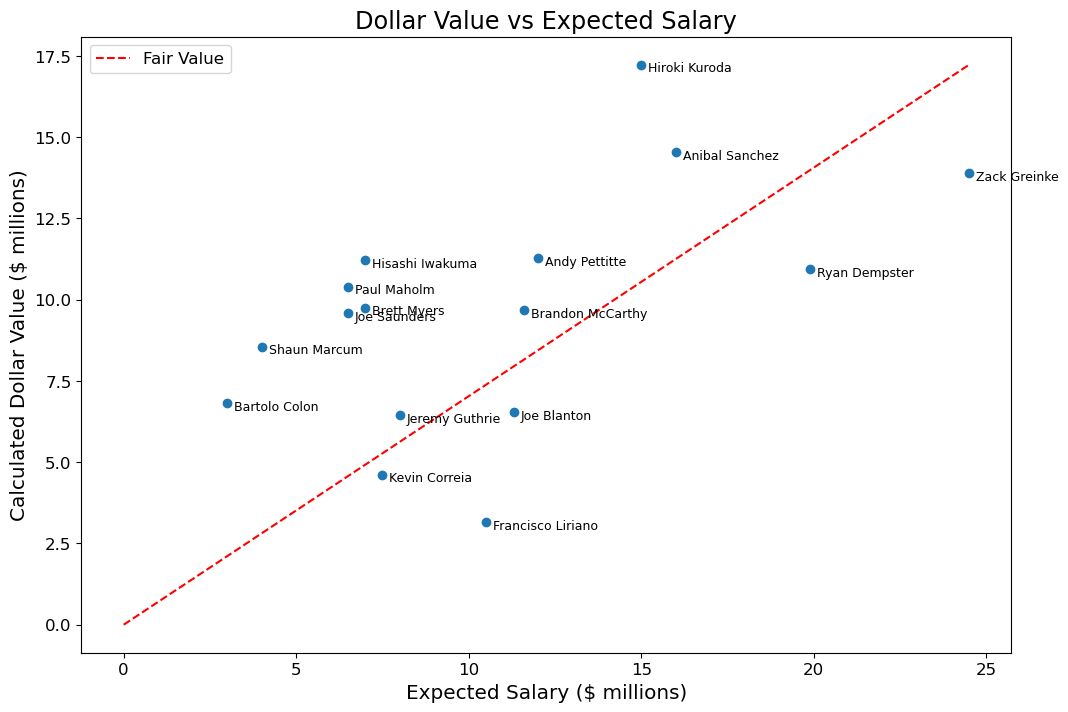

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

# Given DataFrame 'df' with players' names and their corresponding dollar_value
df = pd.DataFrame({
    'name': [
        "Andy Pettitte", "Bartolo Colon", "Brandon McCarthy", "Francisco Liriano",
        "Hiroki Kuroda", "Joe Blanton", "Joe Saunders", "Kevin Correia",
        "Paul Maholm", "Ryan Dempster", "Shaun Marcum", "Anibal Sanchez",
        "Brett Myers", "Hisashi Iwakuma", "Jeremy Guthrie", "Zack Greinke"
    ],
    'dollar_value': [
        11.28, 6.82, 9.67, 3.16, 17.23, 6.54, 9.58, 4.61,
        10.40, 10.94, 8.55, 14.53, 9.75, 11.21, 6.45, 13.90
    ]
})

# The expected_salary data you provided, matched to the names above
expected_salary = [
    12.0, 3.0, 11.6, 10.5, 15.0, 11.3, 6.5, 7.5,
    6.5, 19.9, 4.0, 16.0, 7.0, 7.0, 8.0, 24.5
]

# Add the expected_salary to the DataFrame
df['expected_salary'] = expected_salary

# Now create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(df['expected_salary'], df['dollar_value'])

# Add labels with adjusted positions to minimize overlap
for i, txt in enumerate(df['name']):
    plt.annotate(txt, (df['expected_salary'].iloc[i], df['dollar_value'].iloc[i]), xytext=(5, -5),
                 textcoords='offset points', fontsize=9)

# Add titles and labels
plt.title('Dollar Value vs Expected Salary')
plt.xlabel('Expected Salary ($ millions)')
plt.ylabel('Calculated Dollar Value ($ millions)')

# Add a line representing where dollar value equals expected salary
plt.plot([0, max(df['expected_salary'])], [0, max(df['dollar_value'])], 'r--', label='Fair Value')
plt.legend()
plt.show()


In [184]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Given DataFrame 'df' with players' names, their corresponding dollar_value, IP_pred_2013, RA9_pred_2013, expected_salary, RAR, and WAR
df = pd.DataFrame({
    'name': [
        "Andy Pettitte", "Bartolo Colon", "Brandon McCarthy", "Francisco Liriano",
        "Hiroki Kuroda", "Joe Blanton", "Joe Saunders", "Kevin Correia",
        "Paul Maholm", "Ryan Dempster", "Shaun Marcum", "Anibal Sanchez",
        "Brett Myers", "Hisashi Iwakuma", "Jeremy Guthrie", "Zack Greinke"
    ],
    'dollar_value': [
        11.28, 6.82, 9.67, 3.16, 17.23, 6.54, 9.58, 4.61,
        10.40, 10.94, 8.55, 14.53, 9.75, 11.21, 6.45, 13.90
    ],
    'IP_pred_2013': [
        75.33, 152.33, 111.00, 149.33, 219.67, 190.33, 174.67, 160.67,
        188.00, 173.00, 124.00, 195.67, 65.33, 125.33, 181.67, 212.33
    ],
    'RA9_pred_2013': [
        3.11, 3.66, 3.57, 5.48, 3.52, 4.96, 4.53, 4.71,
        3.83, 3.69, 4.14, 4.37, 4.13, 3.52, 5.40, 3.65
    ],
    'expected_salary': [
        12.0, 3.0, 11.6, 10.5, 15.0, 11.3, 6.5, 7.5,
        6.5, 19.9, 4.0, 16.0, 7.0, 7.0, 8.0, 24.5
    ],
    'RAR': [
        2.0, 1.5, 2.3, 0.8, 3.5, 1.2, 1.9, 1.4,
        1.7, 3.0, 0.7, 2.6, 1.1, 1.4, 1.0, 3.2
    ],
    'WAR': [
        2.4, 2.0, 2.7, 1.0, 3.7, 1.1, 1.5, 1.2,
        1.4, 3.1, 0.9, 3.0, 1.3, 1.5, 1.1, 3.5
    ]
})

# Calculate a composite score based on IP and inverse of RA9
df['Composite_Score'] = df['IP_pred_2013'] / (1 / df['RA9_pred_2013'])

# Sort the DataFrame by the composite score in ascending order
df = df.sort_values(by='Composite_Score')

# Highlighting names of two recommended pitchers
recommended_pitchers = ["Andy Pettitte", "Bartolo Colon"]  # Replace these with actual recommendations
df['name'] = df.apply(lambda x: x['name'].upper() if x['name'] in recommended_pitchers else x['name'], axis=1)

# Display the table in ascending order of composite score
table = tabulate(df[['name', 'expected_salary', 'dollar_value', 'IP_pred_2013', 'RA9_pred_2013', 'RAR', 'WAR', 'Composite_Score']],
                 headers=['Name', 'Expected Salary', 'Dollar Value', 'IP_pred_2013', 'RA9_pred_2013', 'RAR', 'WAR', 'Composite Score'],
                 tablefmt='grid', colalign=("left", "right", "right", "right", "right", "right", "right", "right"))

print(table)

+----+-------------------+-------------------+----------------+----------------+-----------------+-------+-------+-------------------+
|    |              Name |   Expected Salary |   Dollar Value |   IP_pred_2013 |   RA9_pred_2013 |   RAR |   WAR |   Composite Score |
+====+===================+===================+================+================+=================+=======+=======+===================+
| 0  |     ANDY PETTITTE |                12 |          11.28 |          75.33 |            3.11 |     2 |   2.4 |           234.276 |
+----+-------------------+-------------------+----------------+----------------+-----------------+-------+-------+-------------------+
| 12 |       Brett Myers |                 7 |           9.75 |          65.33 |            4.13 |   1.1 |   1.3 |           269.813 |
+----+-------------------+-------------------+----------------+----------------+-----------------+-------+-------+-------------------+
| 2  |  Brandon McCarthy |              11.6 |         

In [179]:
# Sort the DataFrame by composite score in descending order
df_sorted = df.sort_values(by='composite_score', ascending=False)

# Select the top two pitchers with the highest composite scores
recommended_pitchers = df_sorted.head(2)

# Display the recommended pitchers
print(recommended_pitchers[['name', 'composite_score']])

             name  composite_score
15   Zack Greinke             69.0
4   Hiroki Kuroda             62.1


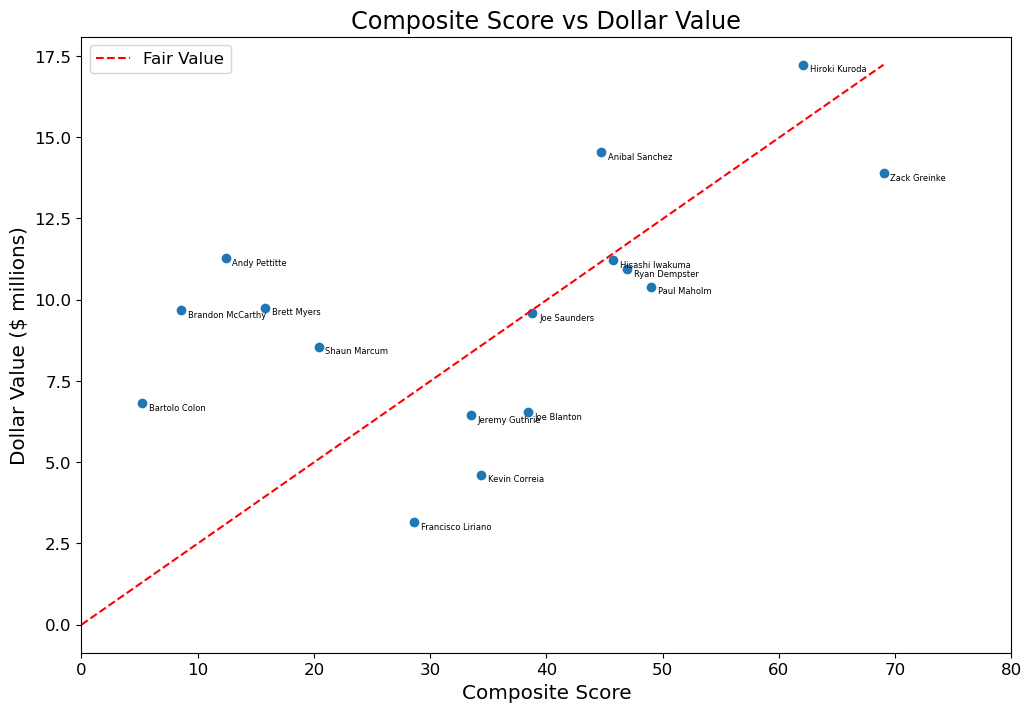

In [178]:
import pandas as pd
import matplotlib.pyplot as plt

# Given DataFrame 'df' with players' names and their corresponding composite score
df = pd.DataFrame({
    'name': [
        "Andy Pettitte", "Bartolo Colon", "Brandon McCarthy", "Francisco Liriano",
        "Hiroki Kuroda", "Joe Blanton", "Joe Saunders", "Kevin Correia",
        "Paul Maholm", "Ryan Dempster", "Shaun Marcum", "Anibal Sanchez",
        "Brett Myers", "Hisashi Iwakuma", "Jeremy Guthrie", "Zack Greinke"
    ],
    'composite_score': [
        12.4, 5.2, 8.6, 28.6, 62.1, 38.4, 38.8, 34.4,
        49.0, 46.9, 20.4, 44.7, 15.8, 45.7, 33.5, 69.0
    ],
    'dollar_value': [
        11.28, 6.82, 9.67, 3.16, 17.23, 6.54, 9.58, 4.61,
        10.40, 10.94, 8.55, 14.53, 9.75, 11.21, 6.45, 13.90
    ]
})

# Create the scatter plot using the new composite score against dollar value
plt.figure(figsize=(12, 8))
plt.scatter(df['composite_score'], df['dollar_value'])

# Add labels with adjusted positions to minimize overlap
for i, txt in enumerate(df['name']):
    plt.annotate(txt, (df['composite_score'].iloc[i], df['dollar_value'].iloc[i]), xytext=(5, -5),
                 textcoords='offset points', fontsize=6)

# Add titles and labels
plt.title('Composite Score vs Dollar Value')
plt.xlabel('Composite Score')
plt.ylabel('Dollar Value ($ millions)')

# Set a fixed range for the x-axis
plt.xlim(0, 80)  # Adjust the range as needed based on your data

# Add a line representing where dollar value equals composite score
plt.plot([0, max(df['composite_score'])], [0, max(df['dollar_value'])], 'r--', label='Fair Value')
plt.legend()
plt.show()


In [1]:
import pandas as pd

# Given DataFrame 'df' with players' names, their corresponding dollar_value, IP_pred_2013, RA9_pred_2013, and expected_salary
df = pd.DataFrame({
    'name': [
        "Andy Pettitte", "Bartolo Colon", "Brandon McCarthy", "Francisco Liriano",
        "Hiroki Kuroda", "Joe Blanton", "Joe Saunders", "Kevin Correia",
        "Paul Maholm", "Ryan Dempster", "Shaun Marcum", "Anibal Sanchez",
        "Brett Myers", "Hisashi Iwakuma", "Jeremy Guthrie", "Zack Greinke"
    ],
    'dollar_value': [
        11.28, 6.82, 9.67, 3.16, 17.23, 6.54, 9.58, 4.61,
        10.40, 10.94, 8.55, 14.53, 9.75, 11.21, 6.45, 13.90
    ],
    'IP_pred_2013': [
        75.33, 152.33, 111.00, 149.33, 219.67, 190.33, 174.67, 160.67,
        188.00, 173.00, 124.00, 195.67, 65.33, 125.33, 181.67, 212.33
    ],
    'RA9_pred_2013': [
        3.11, 3.66, 3.57, 5.48, 3.52, 4.96, 4.53, 4.71,
        3.83, 3.69, 4.14, 4.37, 4.13, 3.52, 5.40, 3.65
    ],
    'expected_salary': [
        12.0, 3.0, 11.6, 10.5, 15.0, 11.3, 6.5, 7.5,
        6.5, 19.9, 4.0, 16.0, 7.0, 7.0, 8.0, 24.5
    ]
})

# Calculate a composite score based on IP and inverse of RA9
df['Composite_Score'] = df['IP_pred_2013'] / (1 / df['RA9_pred_2013'])

# Sort the DataFrame by the composite score in descending order (best to worst)
df = df.sort_values(by='Composite_Score', ascending=False)

# Initialize variables to keep track of selected pitchers and their combined salaries
selected_pitchers = []
total_salary = 0

# Iterate through the sorted DataFrame and select pitchers until the combined salary is below $15 million
for _, row in df.iterrows():
    if total_salary + row['expected_salary'] <= 15.0:
        selected_pitchers.append(row['name'])
        total_salary += row['expected_salary']

    if total_salary >= 15.0 or len(selected_pitchers) == 2:
        break

print("Selected Pitchers for the 2013 Season:")
for pitcher in selected_pitchers:
    print(pitcher)


Selected Pitchers for the 2013 Season:
Jeremy Guthrie
Joe Saunders


In [2]:
import pandas as pd

# Given DataFrame 'df' with players' names, their corresponding dollar_value, IP_pred_2013, RA9_pred_2013, and expected_salary
df = pd.DataFrame({
    'name': [
        "Andy Pettitte", "Bartolo Colon", "Brandon McCarthy", "Francisco Liriano",
        "Hiroki Kuroda", "Joe Blanton", "Joe Saunders", "Kevin Correia",
        "Paul Maholm", "Ryan Dempster", "Shaun Marcum", "Anibal Sanchez",
        "Brett Myers", "Hisashi Iwakuma", "Jeremy Guthrie", "Zack Greinke"
    ],
    'dollar_value': [
        11.28, 6.82, 9.67, 3.16, 17.23, 6.54, 9.58, 4.61,
        10.40, 10.94, 8.55, 14.53, 9.75, 11.21, 6.45, 13.90
    ],
    'IP_pred_2013': [
        75.33, 152.33, 111.00, 149.33, 219.67, 190.33, 174.67, 160.67,
        188.00, 173.00, 124.00, 195.67, 65.33, 125.33, 181.67, 212.33
    ],
    'RA9_pred_2013': [
        3.11, 3.66, 3.57, 5.48, 3.52, 4.96, 4.53, 4.71,
        3.83, 3.69, 4.14, 4.37, 4.13, 3.52, 5.40, 3.65
    ]
})

# Calculate a composite score based on IP and inverse of RA9
df['Composite_Score'] = df['IP_pred_2013'] / (1 / df['RA9_pred_2013'])

# Sort the DataFrame by the composite score in descending order (best to worst)
df = df.sort_values(by='Composite_Score', ascending=False)

# Initialize variables to keep track of selected pitchers and their combined dollar values
selected_pitchers = []
total_dollar_value = 0

# Iterate through the sorted DataFrame and select pitchers until the combined dollar value is below $15 million
for _, row in df.iterrows():
    if total_dollar_value + row['dollar_value'] <= 15.0:
        selected_pitchers.append(row['name'])
        total_dollar_value += row['dollar_value']

    if total_dollar_value >= 15.0 or len(selected_pitchers) == 2:
        break

print("Selected Pitchers for the 2013 Season (based on Dollar Value):")
for pitcher in selected_pitchers:
    print(pitcher)


Selected Pitchers for the 2013 Season (based on Dollar Value):
Jeremy Guthrie
Joe Blanton


# Read in Realizations

In class, we will provide an additional data set with realization for 2013 so you can see how your ensemble models performed on the test data set. The following code will not run correctly until you have that model.

In [9]:
test_real_df = pd.read_csv("../Shared Data (Read Only)/Sabermetrics_SPF/test_saber_realization.csv")

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have already defined IP_pred_2013 and RA9_pred_2013
true_ip_values = test_real_df["IP"]
true_ra9_values = test_real_df["RA9"]

mae_ip = mean_absolute_error(true_ip_values, IP_pred_2013)
mse_ip = mean_squared_error(true_ip_values, IP_pred_2013)
mae_ra9 = mean_absolute_error(true_ra9_values, RA9_pred_2013)
mse_ra9 = mean_squared_error(true_ra9_values, RA9_pred_2013)

print(f"MAE for IP prediction: {mae_ip}")
print(f"MSE for IP prediction: {mse_ip}")
print(f"MAE for RA9 prediction: {mae_ra9}")
print(f"MSE for RA9 prediction: {mse_ra9}")


NameError: name 'IP_pred_2013' is not defined

In [10]:
print("Your IP prediction performance was:")
accuracy(test_real_df["IP"], IP_pred_2013)

Your IP prediction performance was:


NameError: name 'accuracy' is not defined

In [11]:
print("Your RA9 prediction performance was:")
accuracy(test_real_df["RA9"], RA9_pred_2013)

Your RA9 prediction performance was:


NameError: name 'accuracy' is not defined